In [73]:
from dash import Dash, html, dcc, Input, Output
import pandas as pd
import plotly.express as px
import geopandas as gpd
import shapely 
import numpy as np
import dash_bootstrap_components as dbc
from dash.dependencies import Input, Output, State
import dash
from dash_bootstrap_templates import load_figure_template
import plotly.graph_objects as go
import dash_daq as daq
# import sys
# from pathlib import Path
# sys.path.append(str(Path(__file__).parent))
from figure_functions import barchart_heating_systems, boxplot_co2, boxplot_investment
from constants import INJECTION_PRICE, GAS_PRICE, ELECTRICITY_PRICE, ELEC_CO2_INTENSITY, ELEC_CO2_INTENSITY_ELECTRIFICATION, COLS
from tab_layout import make_layout_scenario_maker, make_sliders
from server import app
from functions import map_epc
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from luminalysis_functions import example_cases, dynamic_co2, fit_co2, mod_solar

In [74]:
# df = pd.read_feather('data/archetypes_luminus_trimmed.ftr')
# def hs(scenario_name, gas, elec, oil, heating_consumption):
#     if scenario_name == 'current situation':
#         return 'Oil' if oil >= heating_consumption else 'Gasboiler'
#     elif 'hp' in scenario_name.lower() or 'warmtepomp' in scenario_name.lower():
#         return 'Heat Pump'
#     elif 'gasboiler' in scenario_name.lower():
#         return 'Gasboiler'
#     else:
#         return 'Gasboiler'

# def dhw_system(scenario_name, gas, elec, heating_system):
#     if 'heat pump boiler' in scenario_name.lower():
#         return 'HP Boiler'
#     elif heating_system == 'Heat Pump':
#         if gas == 0:
#             return 'HP Boiler'
#         else:
#             return 'Gasboiler'
#     else:
#         return 'Gasboiler'
# df['heating_system'] = df.apply(lambda x: hs(x.scenario_name,
#                                              x.gas_consumption,
#                                              x.electricity_consumption,
#                                              x.oil_consumption,
#                                              x.heating_consumption), axis = 1)
# df['dhw_system'] = df.apply(lambda x: dhw_system(x.scenario_name,
#                                              x.gas_consumption,
#                                              x.electricity_consumption,
#                                              x.heating_system), axis = 1)

In [75]:


#df = pd.read_csv('data/archetypes_luminus.csv', usecols = COLS)
df = pd.read_feather('data/archetypes_luminus_trimmed.ftr')
df['tco'] = df.total_investment_cost + df.electricity_consumption*15*ELECTRICITY_PRICE['BE'] + df.gas_consumption*GAS_PRICE['BE'] * 15+ df.total_oil_cost -df.electricity_injected * INJECTION_PRICE['BE'] * 15
df['total_co2'] = df.electricity_consumption * 0.171 + df.gas_consumption * 0.056 * 3.6 + df.oil_consumption * 0.074 * 3.6 - df.electricity_injected * 0.171
# df['mapped_epc'] = df.apply(lambda x: map_epc( epc = x.epc_ind, 
#                                                 co2 = x.total_co2 / x.total_floor_area), axis = 1)
optimal_unmodded_temp = df[df.epc_ind<=100].sort_values(by = 'tco', ascending = True).drop_duplicates(subset = 'name', keep = 'first')
optimal_unmodded_temp['dataset'] = 'unmodded'
optimal_modded_temp = df[df.epc_ind<=100].sort_values(by = 'tco', ascending = True).drop_duplicates(subset = 'name', keep = 'first')
optimal_modded_temp['dataset'] = 'modded'

In [76]:
df.total_co2

0         2712.4074
1         2425.8114
2         2180.2554
3         2180.2554
4         2425.8114
            ...    
676355    -126.1980
676356    -505.4760
676357    -505.4760
676358    -126.1980
676359    -505.4760
Name: total_co2, Length: 676360, dtype: float64

In [77]:
x_fit, y_fit_central, y_fit_electrification, fig = fit_co2(central_scenario = ELEC_CO2_INTENSITY, electrification_scenario = ELEC_CO2_INTENSITY_ELECTRIFICATION, returnplot = True)
# Plot the data and the fit

In [78]:
fig.show()

In [79]:
y_fit_central

array([0.17813384, 0.16992409, 0.1620927 , 0.15462225, 0.14749609,
       0.14069836, 0.13421392, 0.12802833, 0.12212782, 0.11649925,
       0.11113008, 0.10600837, 0.10112271, 0.09646221, 0.0920165 ,
       0.08777569, 0.08373032, 0.0798714 , 0.07619032, 0.0726789 ,
       0.06932931])

In [80]:
# # Convert dictionary to arrays
# years = np.array(list(ELEC_CO2_INTENSITY.keys()))
# central_scenario = np.array(list(ELEC_CO2_INTENSITY.values()))
# electrification_scenario = np.array(list(ELEC_CO2_INTENSITY_ELECTRIFICATION.values()))

# # Exponential decay function
# def exp_decay(x, a, b):
#     return a * np.exp(b * x)

# # Fit the central scenario data
# popt_central, pcov_central = curve_fit(exp_decay, years - 2020, central_scenario, p0=(0.171, -0.1))
# a_central, b_central = popt_central

# # Fit the electrification scenario data
# popt_electrification, pcov_electrification = curve_fit(exp_decay, years - 2020, electrification_scenario, p0=(0.171, -0.1))
# a_electrification, b_electrification = popt_electrification

# # Generate data for plotting
# x_fit = np.linspace(2020, 2040, 21)
# y_fit_central = exp_decay(x_fit - 2020, *popt_central)
# y_fit_electrification = exp_decay(x_fit - 2020, *popt_electrification)
# Plot the data and the fit
# fig = plt.figure(figsize=(10, 6))
# plt.plot(years, central_scenario, 'o', label='Central Scenario Data')
# plt.plot(x_fit, y_fit_central, '-', label=f'Central Scenario Fit: a={a_central:.3f}, b={b_central:.3f}')
# plt.plot(years, electrification_scenario, 'o', label='Electrification Scenario Data')
# plt.plot(x_fit, y_fit_electrification, '-', label=f'Electrification Scenario Fit: a={a_electrification:.3f}, b={b_electrification:.3f}')
# plt.xlabel('Year')
# plt.ylabel('CO2 Intensity (kg/kWh)')
# plt.title('CO2 Intensity Projections until 2040')
# plt.legend()
# plt.grid(True)
# plt.show()


In [81]:
df = dynamic_co2(df, x_fit, y_fit_central, start_year = 2025, solar = True)
df = mod_solar(df, co2_flag=True)

years = np.arange(2025, 2025 + len(y_fit_central[5:]))
for year in range(len(years)):
    df[f'solar_injection_emissions_{year + 2025}'] = (
        df[f'modified_emissions_{year + 2025}'] - 
        df[f'emissions_{year + 2025}'] 
    )

In [82]:
df.head()

,Unnamed: 0,epc_ind,epc_label,total_co2,scenario_name,gas_consumption,oil_consumption,total_floor_area,heating_consumption,electricity_injected,...,solar_injection_emissions_2031,solar_injection_emissions_2032,solar_injection_emissions_2033,solar_injection_emissions_2034,solar_injection_emissions_2035,solar_injection_emissions_2036,solar_injection_emissions_2037,solar_injection_emissions_2038,solar_injection_emissions_2039,solar_injection_emissions_2040
0,0,339,4,2712.4074,current situation,11959,0,97,8803,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,296,4,2425.8114,PV normal with battery,11959,0,97,8803,1135,...,120.319501,114.774271,109.484607,104.438731,99.625407,95.033917,90.654038,86.476016,82.490549,78.688763
2,0,259,4,2180.2554,PV full roof with battery,11959,0,97,8803,2349,...,249.013663,237.537236,226.589729,216.146766,206.185093,196.682530,187.617916,178.971067,170.722731,162.854541
3,0,259,4,2180.2554,PV full roof,11959,0,97,8803,2619,...,277.635923,264.840366,252.634526,240.991222,229.884529,219.289717,209.183193,199.542455,190.346034,181.573453
4,0,296,4,2425.8114,PV normal,11959,0,97,8803,1242,...,131.662397,125.594401,119.806064,114.284497,109.017406,103.993062,99.200277,94.628381,90.267191,86.106998


In [83]:
df[['electricity_consumption', 'gas_consumption', 'total_co2', 'pv_production', 'oil_consumption', 'heating_consumption', 'domestic_hot_water_consumption',  'total_emissions']]

,electricity_consumption,gas_consumption,total_co2,pv_production,oil_consumption,heating_consumption,domestic_hot_water_consumption,total_emissions
0,1763,11959,2712.4074,0,0,8803,3155,41427.278969
1,1222,11959,2425.8114,1676,0,8803,3155,38715.706262
2,1000,11959,2180.2554,3112,0,8803,3155,36392.425590
3,1270,11959,2180.2554,3112,0,8803,3155,36392.425590
4,1329,11959,2425.8114,1676,0,8803,3155,38715.706262
...,...,...,...,...,...,...,...,...
676355,3289,0,-126.1980,4787,0,1491,1275,-1193.998006
676356,3808,0,-505.4760,7899,0,1491,1275,-4782.463557
676357,4189,0,-505.4760,7899,0,1491,1275,-4782.463557
676358,2896,0,-126.1980,4787,0,1491,1275,-1193.998006


In [84]:
testcase = df[df.epc_ind <= 100].sort_values(by = 'tco', ascending = True).drop_duplicates(subset = 'name', keep = 'first')
testcase = testcase[testcase.name == 'type_0']

In [85]:
testcase['total_co2'].values * np.array([1 for i in range(16)]).cumsum()

array([  780.885,  1561.77 ,  2342.655,  3123.54 ,  3904.425,  4685.31 ,
        5466.195,  6247.08 ,  7027.965,  7808.85 ,  8589.735,  9370.62 ,
       10151.505, 10932.39 , 11713.275, 12494.16 ])

In [86]:
testcase = df[(df.epc_ind<100) & (df.name == 'type_0')].sort_values(by = 'tco', ascending = False).drop_duplicates(subset = ['heating_system', 'dhw_system'], keep = 'first')

In [87]:
testcase[['electricity_consumption', 'gas_consumption', 'total_co2', 'pv_production', 'oil_consumption', 'heating_consumption', 'domestic_hot_water_consumption',  'total_emissions', 'heating_system', 'dhw_system', 'scenario_name']]

,electricity_consumption,gas_consumption,total_co2,pv_production,oil_consumption,heating_consumption,domestic_hot_water_consumption,total_emissions,heating_system,dhw_system,scenario_name
3162,2763,0,78.6600,3112,0,533,1275,744.226399,Heat Pump,HP Boiler,"Triple glass, incl. frame + Internal wall insu..."
2245,1488,3155,496.6830,3112,0,533,3155,8858.192966,Heat Pump,Gasboiler,"Triple glass, incl. frame + Internal wall insu..."
3153,2298,2918,616.8258,2872,0,2918,1275,9682.487341,Gasboiler,HP Boiler,"Triple glass, incl. frame + Internal wall insu..."
2161,1000,6074,993.8394,3112,0,2918,3155,17409.769590,Gasboiler,Gasboiler,"Triple glass, incl. frame + Internal wall insu..."


In [88]:
# split_scenarios = df['scenario_name'].str.split('+')
# all_entries = list(split_scenarios.values.flatten())
#set([item.strip() for sublist in all_entries for item in sublist])

In [89]:
df[(df.heating_system == 'Heat Pump') & (df.gas_consumption > 0)][['electricity_consumption', 'gas_consumption', 'total_co2', 'pv_production', 'oil_consumption', 'heating_consumption', 'domestic_hot_water_consumption',  'total_emissions', 'heating_system', 'scenario_name']]

,electricity_consumption,gas_consumption,total_co2,pv_production,oil_consumption,heating_consumption,domestic_hot_water_consumption,total_emissions,heating_system,scenario_name
17,3284,3155,1197.612,0,0,1520,3155,15489.897338,Heat Pump,Air-water HP - no floor heating
18,3206,3155,1184.274,0,0,1442,3155,15363.702426,Heat Pump,Air-water HP - floor heating
49,3203,3155,1183.761,0,0,1440,3155,15358.848776,Heat Pump,"Double glass, incl. frame + Air-water HP - no ..."
57,3036,3155,1155.204,0,0,1272,3155,15088.662235,Heat Pump,"Double glass, incl. frame + Ground-water warmt..."
59,3129,3155,1171.107,0,0,1366,3155,15239.125399,Heat Pump,"Double glass, incl. frame + Air-water HP - flo..."
...,...,...,...,...,...,...,...,...,...,...
675257,2532,3155,-87.624,7899,0,1491,3155,3329.885126,Heat Pump,"Triple glass, incl. frame + Internal wall insu..."
675258,1322,3155,368.604,3591,0,1491,3155,7646.398242,Heat Pump,"Triple glass, incl. frame + Internal wall insu..."
675259,2913,3155,-87.624,7899,0,1491,3155,3329.885126,Heat Pump,"Triple glass, incl. frame + Internal wall insu..."
675260,996,3155,368.604,3591,0,1491,3155,7646.398242,Heat Pump,"Triple glass, incl. frame + Internal wall insu..."


In [108]:
testcase[['electricity_consumption', 'electricity_injected', 'emissions_2025', 'emissions_2026', 'emissions_2027','modified_emissions_2027','gas_consumption', 'total_co2', 'total_co2_modified','pv_production', 'oil_consumption', 'heating_consumption', 'domestic_hot_water_consumption',  'total_emissions', 'heating_system', 'dhw_system', 'scenario_name']]

,electricity_consumption,electricity_injected,emissions_2025,emissions_2026,emissions_2027,modified_emissions_2027,gas_consumption,total_co2,total_co2_modified,pv_production,oil_consumption,heating_consumption,domestic_hot_water_consumption,total_emissions,heating_system,dhw_system,scenario_name
3162,2763,2303,64.721245,61.738402,58.893031,353.742270,0,78.6600,472.4730,3112,0,533,1275,744.226399,Heat Pump,HP Boiler,"Triple glass, incl. frame + Internal wall insu..."
2245,1488,2303,521.378838,526.663658,531.704913,826.554152,3155,496.6830,890.4960,3112,0,533,3155,8858.192966,Heat Pump,Gasboiler,"Triple glass, incl. frame + Internal wall insu..."
3153,2298,2131,611.765426,610.682524,609.649531,882.477898,2918,616.8258,981.2268,2872,0,2918,1275,9682.487341,Gasboiler,HP Boiler,"Triple glass, incl. frame + Internal wall insu..."
2161,1000,2349,1034.716315,1043.463826,1051.808186,1352.546728,6074,993.8394,1395.5184,3112,0,2918,3155,17409.769590,Gasboiler,Gasboiler,"Triple glass, incl. frame + Internal wall insu..."


In [91]:
testcase[testcase.heating_system == 'Gasboiler']

,Unnamed: 0,epc_ind,epc_label,total_co2,scenario_name,gas_consumption,oil_consumption,total_floor_area,heating_consumption,electricity_injected,...,solar_injection_emissions_2031,solar_injection_emissions_2032,solar_injection_emissions_2033,solar_injection_emissions_2034,solar_injection_emissions_2035,solar_injection_emissions_2036,solar_injection_emissions_2037,solar_injection_emissions_2038,solar_injection_emissions_2039,solar_injection_emissions_2040
3153,0,80,2,616.8258,"Triple glass, incl. frame + Internal wall insu...",2918,0,97,2918,2131,...,225.903838,215.492486,205.560968,196.087168,187.049993,178.429319,170.205951,162.361577,154.878732,147.740752
2161,0,72,2,993.8394,"Triple glass, incl. frame + Internal wall insu...",6074,0,97,2918,2349,...,249.013663,237.537236,226.589729,216.146766,206.185093,196.682530,187.617916,178.971067,170.722731,162.854541


In [92]:
for x in zip(testcase.heating_system.unique(), testcase.dhw_system.unique()):
    print(x)

('Heat Pump', 'HP Boiler')
('Gasboiler', 'Gasboiler')


In [93]:
fig = go.Figure()
for heating_system in testcase.heating_system.unique():
    for dhw_system in testcase.dhw_system.unique():
        tmp = testcase[(testcase.heating_system == heating_system) & (testcase.dhw_system == dhw_system)]
        years = np.arange(2025, 2025 + len(y_fit_central[5:]))
        total_co2_cumulative = tmp['total_co2'].values * np.array([1 for i in range(16)]).cumsum()
        modified_total_co2_cumulative = tmp['total_co2_modified'].values * np.array([1 for i in range(16)]).cumsum()
        new_emissions_cumulative = tmp[[f'emissions_{year + 2025}' for year in range(len(y_fit_central[5:]))]].cumsum(axis=1)
        modified_new_emissions_cumulative = tmp[[f'modified_emissions_{year + 2025}' for year in range(len(y_fit_central[5:]))]].cumsum(axis=1)
        #new_emissions_cumulative = tmp[[f'emissions_{year + 2025}' for year in range(len(y_fit_central[5:]))]]
        # Create the Plotly scatter plot


        # Add total_co2 cumulative emissions
        # fig.add_trace(go.Scatter(
        #     x=years,
        #     y=total_co2_cumulative,
        #     mode='lines+markers',
        #     name='Total CO2 (Original)'
        # ))
        fig.add_trace(go.Scatter(
            x=years,
            y=new_emissions_cumulative.values[0],
            mode='lines+markers',
            name=f'{heating_system} + {dhw_system}'
        ))
        fig.add_trace(go.Scatter(
            x=years,
            y=modified_new_emissions_cumulative.values[0],
            mode='lines+markers',
            name=f'modified {heating_system} + {dhw_system}'
        ))
        fig.add_trace(go.Scatter(
            x=years,
            y=total_co2_cumulative,
            mode='lines+markers',
            name=f'standard {heating_system} + {dhw_system}'
        ))
        fig.add_trace(go.Scatter(
            x=years,
            y=modified_total_co2_cumulative,
            mode='lines+markers',
            name=f'standard modified {heating_system} + {dhw_system}'
        ))
        
# # Add newly calculated cumulative emissions
# tmp = testcase[testcase.heating_system == 'Heat Pump']
# years = np.arange(2025, 2025 + len(y_fit_central[5:]))
# #total_co2_cumulative = tmp['total_co2'].values * np.array([1 for i in range(16)]).cumsum()
# new_emissions_cumulative = tmp[[f'emissions_{year + 2025}' for year in range(len(y_fit_central[5:]))]].cumsum(axis=1)
# for i in range(new_emissions_cumulative.shape[0]):
#     fig.add_trace(go.Scatter(
#         x=years,
#         y=new_emissions_cumulative.iloc[i],
#         mode='lines+markers',
#         name=f'{tmp.heating_system.values}'
#     ))

# Update layout
fig.update_layout(
    title='Yearly Cumulative Emissions',
    xaxis_title='Year',
    yaxis_title='Cumulative Emissions (kg CO2)',
    legend_title='Emission Categories'
)

# Show the plot
fig.show()

In [101]:
testcase.columns

Index(['Unnamed: 0', 'epc_ind', 'epc_label', 'total_co2', 'scenario_name',
       'gas_consumption', 'oil_consumption', 'total_floor_area',
       'heating_consumption', 'electricity_injected', 'total_investment_cost',
       'electricity_consumption', 'domestic_hot_water_consumption',
       'total_subsidies', 'total_oil_cost', 'pv_production', 'name',
       'building_type', 'construction_year', 'scale_kadaster',
       'heating_system', 'tco', 'dhw_system', 'emissions_2025',
       'modified_emissions_2025', 'emissions_2026', 'modified_emissions_2026',
       'emissions_2027', 'modified_emissions_2027', 'emissions_2028',
       'modified_emissions_2028', 'emissions_2029', 'modified_emissions_2029',
       'emissions_2030', 'modified_emissions_2030', 'emissions_2031',
       'modified_emissions_2031', 'emissions_2032', 'modified_emissions_2032',
       'emissions_2033', 'modified_emissions_2033', 'emissions_2034',
       'modified_emissions_2034', 'emissions_2035', 'modified_emission

In [100]:
years = np.arange(2025, 2025 + len(y_fit_central[5:]))
testcase2 = pd.DataFrame()
testcase2.index = years
for year in range(len(years)):
    
    testcase2.loc[year, 'co2_gas'] = testcase.loc['gas_consumption'] * 0.056 * 3.6
    # co2_electricity = scenario[year]
    # df[f'emissions_{year + start_year}'] = (
    #     df['electricity_consumption'] * co2_electricity +
    #     df['gas_consumption'] * co2_intensity_gas +
    #     df['oil_consumption'] * co2_intensity_oil -
    #     df['electricity_injected'] * co2_electricity
    # )

KeyError: 'gas_consumption'

In [ ]:
fig = px.area(testcase, x="year", y="pop", color="continent", line_group="country")
fig.show()

In [96]:
testcase.name

3162    type_0
2245    type_0
3153    type_0
2161    type_0
Name: name, dtype: object

In [72]:
import plotly.express as px
df = px.data.gapminder()
fig = px.area(df, x="year", y="pop", color="continent", line_group="country")
fig.show()

In [110]:
testcase2 = testcase[testcase.heating_system == 'Heat Pump']
# Sample DataFrame named testcase
# testcase = pd.DataFrame({
#     'total_emissions_2025': [100, 120, 130],
#     'solar_emissions_2025': [30, 40, 50],
#     'total_emissions_2026': [110, 125, 135],
#     'solar_emissions_2026': [35, 45, 55],
#     # Add more years as necessary
# })

# Transform the DataFrame
years = range(2025, 2041)
total_emissions = []
solar_emissions = []

for year in years:
    total_emissions.append((testcase2[f'modified_emissions_{year}']).sum())
    solar_emissions.append((testcase2[f'solar_injection_emissions_{year}'] * -1).sum())

emissions_df = pd.DataFrame({
    'Year': years,
    'Total Emissions': total_emissions,
    'Solar Emissions': solar_emissions
})

# Melt the DataFrame for plotly express
emissions_df = emissions_df.melt(id_vars='Year', value_vars=['Solar Emissions', 'Total Emissions', ],
                                 var_name='Emissions Type', value_name='Emissions')

# Create the area plot
fig = px.area(emissions_df, x='Year', y='Emissions', color='Emissions Type',
              labels={'Emissions': 'Emissions (units)', 'Year': 'Year'},
              title='Total Emissions and Solar Emissions Over Years')

# Show the plot
fig.show()

ValueError: No axis named 1 for object type Series

In [114]:

# Transform the DataFrame to get yearly emissions
years = range(2025, 2041)
total_emissions = []
solar_emissions = []

# for year in years:
#     if f'total_emissions_{year}' in testcase.columns and f'solar_emissions_{year}' in testcase.columns:
#         total_emissions.append(testcase[f'emissions_{year}'].sum())
#         solar_emissions.append(testcase[f'solar_injection_emissions_{year}'].sum())
#     else:
#         total_emissions.append(0)
#         solar_emissions.append(0)
for year in years:
    total_emissions.append((testcase2[f'modified_emissions_{year}']).sum())
    solar_emissions.append((testcase2[f'solar_injection_emissions_{year}'] * -1).sum())

# Calculate cumulative sums
total_emissions_cumulative = pd.Series(total_emissions).cumsum().tolist()
solar_emissions_cumulative = pd.Series(solar_emissions).cumsum().tolist()

# Create DataFrame for cumulative emissions
emissions_df = pd.DataFrame({
    'Year': years,
    'Total Emissions': total_emissions_cumulative,
    'Solar Emissions': solar_emissions_cumulative
})

# Melt the DataFrame for plotly express
emissions_df = emissions_df.melt(id_vars='Year', value_vars=['Total Emissions', 'Solar Emissions'],
                                 var_name='Emissions Type', value_name='Cumulative Emissions')

# Create the area plot
fig = px.area(emissions_df, x='Year', y='Cumulative Emissions', color='Emissions Type',
              labels={'Cumulative Emissions': 'Cumulative Emissions (units)', 'Year': 'Year'},
              title='Cumulative Total Emissions and Solar Emissions Over Years')

# Show the plot
fig.show()


In [118]:
testcase2 = df[(df.epc_ind<100)].sort_values(by = 'tco', ascending = False).drop_duplicates(subset = ['name'], keep = 'first')


# Melt the DataFrame to make it long format
emissions_df = pd.melt(testcase2, id_vars=['building_type'], var_name='year', value_name='emissions')

In [120]:
emissions_df.year.value_counts()

year
Unnamed: 0                        135
epc_ind                           135
epc_label                         135
total_co2                         135
scenario_name                     135
                                 ... 
solar_injection_emissions_2036    135
solar_injection_emissions_2037    135
solar_injection_emissions_2038    135
solar_injection_emissions_2039    135
solar_injection_emissions_2040    135
Name: count, Length: 74, dtype: int64

In [115]:
testcase2 = df[(df.epc_ind<100)].sort_values(by = 'tco', ascending = False).drop_duplicates(subset = ['name'], keep = 'first')


# Melt the DataFrame to make it long format
emissions_df = pd.melt(testcase2, id_vars=['building_type'], var_name='year', value_name='emissions')

# Split the year and emission type
emissions_df[['emission_type', 'year']] = emissions_df['year'].str.split('_emissions_', expand=True)
emissions_df['year'] = emissions_df['year'].astype(int)

# Pivot to have separate columns for total and solar emissions
emissions_pivot = emissions_df.pivot_table(index=['building_type', 'year'], columns='emission_type', values='emissions').reset_index()

# Calculate cumulative emissions
emissions_pivot['Total Emissions Cumulative'] = emissions_pivot.groupby('building_type')['total'].cumsum()
emissions_pivot['Solar Emissions Cumulative'] = emissions_pivot.groupby('building_type')['solar'].cumsum()

# Melt again to get the cumulative emissions in long format
cumulative_emissions_df = emissions_pivot.melt(id_vars=['building_type', 'year'], 
                                               value_vars=['Total Emissions Cumulative', 'Solar Emissions Cumulative'],
                                               var_name='Emissions Type', value_name='Cumulative Emissions')

# Rename Emissions Type to distinguish total and solar emissions
cumulative_emissions_df['Emissions Type'] = cumulative_emissions_df['Emissions Type'].replace({
    'Total Emissions Cumulative': 'Total Emissions',
    'Solar Emissions Cumulative': 'Solar Emissions'
})

# Create the area plot
fig = px.area(cumulative_emissions_df, x='year', y='Cumulative Emissions', color='Emissions Type',
              line_group='building_type', labels={'Cumulative Emissions': 'Cumulative Emissions (units)', 'year': 'Year'},
              title='Cumulative Total Emissions and Solar Emissions Over Years by Building Type')

# Show the plot
fig.show()


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

In [128]:
emissions_df

,building_type,year,emissions,emission_type
0,OPEN,None,-592.762184,emissions_2025
1,OPEN,None,-703.632490,emissions_2025
2,OPEN,None,-612.600652,emissions_2025
3,OPEN,None,-578.692348,emissions_2025
4,OPEN,None,-524.804877,emissions_2025
...,...,...,...,...
6475,GESLOTEN,2040,185.663882,solar_injection
6476,GESLOTEN,2040,159.665393,solar_injection
6477,GESLOTEN,2040,159.665393,solar_injection
6478,GESLOTEN,2040,159.665393,solar_injection


In [129]:
emission_columns

['emissions_2025',
 'modified_emissions_2025',
 'emissions_2026',
 'modified_emissions_2026',
 'emissions_2027',
 'modified_emissions_2027',
 'emissions_2028',
 'modified_emissions_2028',
 'emissions_2029',
 'modified_emissions_2029',
 'emissions_2030',
 'modified_emissions_2030',
 'emissions_2031',
 'modified_emissions_2031',
 'emissions_2032',
 'modified_emissions_2032',
 'emissions_2033',
 'modified_emissions_2033',
 'emissions_2034',
 'modified_emissions_2034',
 'emissions_2035',
 'modified_emissions_2035',
 'emissions_2036',
 'modified_emissions_2036',
 'emissions_2037',
 'modified_emissions_2037',
 'emissions_2038',
 'modified_emissions_2038',
 'emissions_2039',
 'modified_emissions_2039',
 'emissions_2040',
 'modified_emissions_2040',
 'solar_injection_emissions_2025',
 'solar_injection_emissions_2026',
 'solar_injection_emissions_2027',
 'solar_injection_emissions_2028',
 'solar_injection_emissions_2029',
 'solar_injection_emissions_2030',
 'solar_injection_emissions_2031',
 's

In [156]:
emissions_df.year.astype(int)

0       2025
1       2025
2       2025
3       2025
4       2025
        ... 
6475    2040
6476    2040
6477    2040
6478    2040
6479    2040
Name: year, Length: 6480, dtype: int64

In [149]:
testcase2 = df[(df.epc_ind<100)].sort_values(by = 'tco', ascending = False).drop_duplicates(subset = ['name'], keep = 'first')


# Filter to include only the emissions columns and id_vars
emission_columns = [col for col in testcase2.columns if 'emissions' in col and 'total' not in col]
id_vars = ['building_type']

# Melt the DataFrame to make it long format
emissions_df = pd.melt(testcase2, id_vars=id_vars, value_vars=emission_columns, var_name='year', value_name='emissions')

# Split the year and emission type
emissions_df['emission_type'] = emissions_df.year.apply(lambda x: '_'.join(x.split('_')[:-1]))
emissions_df['year'] = emissions_df.year.apply(lambda x: x.split('_')[-1])

#emissions_df[['emission_type', 'year']] = emissions_df['year'].str.split('_emissions_', expand=True)

emissions_df['year'] = emissions_df['year'].astype(int)

In [157]:


testcase2 = df[(df.epc_ind<100)].sort_values(by = 'tco', ascending = False).drop_duplicates(subset = ['name'], keep = 'first')


# Filter to include only the emissions columns and id_vars
emission_columns = [col for col in testcase2.columns if 'emissions' in col and 'total' not in col]
id_vars = ['building_type']

# Melt the DataFrame to make it long format
emissions_df = pd.melt(testcase2, id_vars=id_vars, value_vars=emission_columns, var_name='year', value_name='emissions')

# Split the year and emission type
emissions_df['emission_type'] = emissions_df.year.apply(lambda x: '_'.join(x.split('_')[:-1]))
emissions_df['year'] = emissions_df.year.apply(lambda x: x.split('_')[-1])

#emissions_df[['emission_type', 'year']] = emissions_df['year'].str.split('_emissions_', expand=True)

emissions_df['year'] = emissions_df.year.astype(int)

# Pivot to have separate columns for total and solar emissions
emissions_pivot = emissions_df.pivot_table(index=['building_type', 'year'], columns='emission_type', values='emissions').reset_index()

# Calculate cumulative emissions
emissions_pivot['Total Emissions Cumulative'] = emissions_pivot.groupby('building_type')['total'].cumsum()
emissions_pivot['Solar Emissions Cumulative'] = emissions_pivot.groupby('building_type')['solar'].cumsum()

# Melt again to get the cumulative emissions in long format
cumulative_emissions_df = emissions_pivot.melt(id_vars=['building_type', 'year'], 
                                               value_vars=['Total Emissions Cumulative', 'Solar Emissions Cumulative'],
                                               var_name='Emissions Type', value_name='Cumulative Emissions')

# Rename Emissions Type to distinguish total and solar emissions
cumulative_emissions_df['Emissions Type'] = cumulative_emissions_df['Emissions Type'].replace({
    'Total Emissions Cumulative': 'Total Emissions',
    'Solar Emissions Cumulative': 'Solar Emissions'
})

# Create the area plot
fig = px.area(cumulative_emissions_df, x='year', y='Cumulative Emissions', color='Emissions Type',
              line_group='building_type', labels={'Cumulative Emissions': 'Cumulative Emissions (units)', 'year': 'Year'},
              title='Cumulative Total Emissions and Solar Emissions Over Years by Building Type')

# Show the plot
fig.show()


KeyError: 'Column not found: total'

In [183]:

# Assuming `df` is already defined and includes the relevant columns

# Filter the DataFrame
testcase2 = df[(df.epc_ind < 100)].sort_values(by='tco', ascending=False).drop_duplicates(subset=['name'], keep='first')

# Filter to include only the emissions columns and id_vars
emission_columns = [col for col in testcase2.columns if 'emissions' in col and 'total' not in col]
id_vars = ['building_type']

# Melt the DataFrame to make it long format
emissions_df = pd.melt(testcase2, id_vars=id_vars, value_vars=emission_columns, var_name='year', value_name='emissions')

# Split the year and emission type
emissions_df['emission_type'] = emissions_df.year.apply(lambda x: '_'.join(x.split('_')[:-1]))
emissions_df['year'] = emissions_df.year.apply(lambda x: x.split('_')[-1])
emissions_df['year'] = emissions_df.year.astype(int)

# Pivot to have separate columns for each type of emissions
emissions_pivot = emissions_df.pivot_table(index=['building_type', 'year'], columns='emission_type', values='emissions').reset_index()

# Calculate cumulative emissions for each emission type
cumulative_columns = []
for emission_type in emission_columns:
    emission_type_name = '_'.join(emission_type.split('_')[:-1])
    cumulative_column_name = f'{emission_type_name}_Cumulative'
    emissions_pivot[cumulative_column_name] = emissions_pivot.groupby('building_type')[emission_type_name].cumsum()
    cumulative_columns.append(cumulative_column_name)

# Melt again to get the cumulative emissions in long format
cumulative_emissions_df = emissions_pivot.melt(id_vars=['building_type', 'year'], 
                                               value_vars=cumulative_columns,
                                               var_name='Emissions Type', value_name='Cumulative Emissions')

# Rename Emissions Type to distinguish the cumulative emissions
cumulative_emissions_df['Emissions Type'] = cumulative_emissions_df['Emissions Type'].replace({
    'solar_Cumulative': 'Solar Emissions',
    
    # Add other emission types here if needed
})
color_discrete_map = {
    'solar_injection_emissions_Cumulative': 'rgb(255, 204, 0)',  # Yellow
    'modified_emissions_Cumulative': 'rgb(255, 0, 0)',  # Yellow
    # Add other emission types here if needed, with distinct colors
}
cumulative_emissions_df.loc[cumulative_emissions_df['Emissions Type'] == 'solar_injection_emissions_Cumulative', 'Cumulative Emissions'] = cumulative_emissions_df.loc[cumulative_emissions_df['Emissions Type'] == 'solar_injection_emissions_Cumulative', 'Cumulative Emissions'] * -1
# Create the area plot
fig = px.area(cumulative_emissions_df[cumulative_emissions_df['Emissions Type']!= 'emissions_Cumulative'], x='year', y='Cumulative Emissions', color='building_type',
               line_group='Emissions Type',labels={'Cumulative Emissions': 'Cumulative Emissions (units)', 'year': 'Year'},
              title='Cumulative Emissions Over Years by Building Type', color_discrete_map = color_discrete_map)
fig.update_layout(yaxis=dict(zeroline=True, zerolinewidth=2, zerolinecolor='black'))

# Show the plot
fig.show()

In [178]:
cumulative_emissions_df['Emissions Type'].value_counts()

Emissions Type
emissions_Cumulative                    48
modified_emissions_Cumulative           48
solar_injection_emissions_Cumulative    48
Name: count, dtype: int64

In [181]:
cumulative_emissions_df[(cumulative_emissions_df['Emissions Type'] == 'solar_injection_emissions_Cumulative') & (cumulative_emissions_df['Cumulative Emissions'] > 0)]

,building_type,year,Emissions Type,Cumulative Emissions


<Axes: >

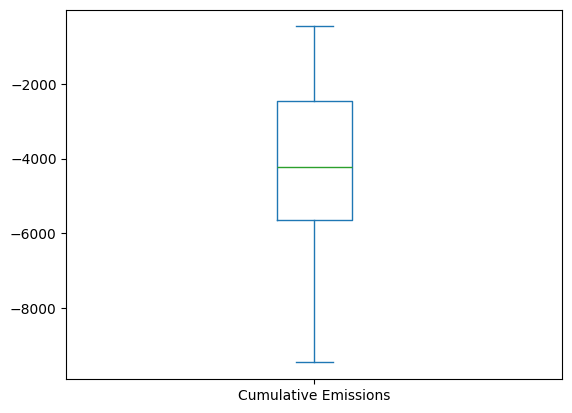

In [182]:
cumulative_emissions_df[(cumulative_emissions_df['Emissions Type'] == 'solar_injection_emissions_Cumulative')]['Cumulative Emissions'].plot(kind = 'box')